# Aufenthaltsdauer in Zuständen aus Rohdaten

### Zustände

* Zuhause -> 1
* Arbeit -> 2 
* Einkaufen -> 3 
* Freizeit -> 4
* Sonstiges -> 5

In [1]:
import pandas as pd
import numpy as np 
import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
# einlesen des bearbeiteten Trips-Datensatz
df = pd.read_csv(r"C:\Users\thoma\Desktop\ev-modelling-repo\Rohdaten\NHTS_trips_processed.csv")

## Ermitteln des Aufenthalts in Zielzuständen der Trips

In [9]:
# hinzufügen einer Spalte zum Eintragen der Aufenthaltsdauern
df["Stay_duration"] = 0
df.head()

,ID,Type_day,TRPTRANS,Trip_no,Whyfrom,Whyto,Distance,Trip_duration,Departure_hhmm,Arrival_hhmm,Departure,Arrival,Departure_t,Stay_duration
0,300000071,1,3,1,1,4,8.439,15,1000,1015,600,615,40,0
1,300000071,1,3,2,4,1,8.286,20,1510,1530,910,930,61,0
2,300000072,1,6,1,2,1,135.191,120,700,900,420,540,28,0
3,300000072,1,6,2,1,2,131.367,150,1800,2030,1080,1230,72,0
4,300000073,1,3,1,1,2,3.621,15,845,900,525,540,35,0


### Auf Wochentage filtern

In [10]:
filt = df["Type_day"] == 6
df = df[filt]

## Sortieren des DataFrames zunächst nach ID und dann nach Wegnummer
-> so befinden sich alle Trips derselben Person in aufsteigender Reihenfolge hintereinander

In [11]:
df = df.sort_values(by=['ID', 'Trip_no'])

In [12]:
# reihenweise Indizierung nach Umsortierung wiederherstellen
df.reset_index(inplace=True)
df.tail()

,index,ID,Type_day,TRPTRANS,Trip_no,Whyfrom,Whyto,Distance,Trip_duration,Departure_hhmm,Arrival_hhmm,Departure,Arrival,Departure_t,Stay_duration
85122,795032,407941083,6,3,4,4,1,-1.000,17,2337,2354,1417,1434,94,0
85123,795064,407941582,6,3,1,1,3,5.464,15,930,945,570,585,38,0
85124,795065,407941582,6,3,2,3,1,5.464,15,1015,1030,615,630,41,0
85125,795146,407942911,6,3,1,1,3,2.596,10,1330,1340,810,820,54,0
85126,795147,407942911,6,3,2,3,1,2.515,10,1355,1405,835,845,56,0


In [13]:
# entfernen der alten Index Spalte
df.drop(columns=["index"], inplace=True)

## Berechnen der Aufenthalte in den Zuständen 

In [14]:
# Auswertung Teihe für Reihe, Zuordnung der Trips über ID
def calc_aufenthalt(df):
    rows = df.shape[0]
    for i in range(rows):
        # letzter Trip der Person -> Aufenthalt = Zeit bis zum ersten Trip 
        if (i == rows-1) or (df.at[i+1, "ID"] != df.at[i, "ID"]):
            # Beispiel: Wenn Wegnummer = 3 liegt Index des ersten Wegs 2 Schritte zurück
            index_first_trip = i - (df.at[i, "Trip_no"] - 1) 
            start_first_trip = df.at[index_first_trip, "Departure"]
            end_trip = df.at[i,"Arrival"]
            # Gesamtaufenthalt = 
            # Rest des Tages + Zeit bis zum ersten Trip
            if end_trip > start_first_trip:           
                df.at[i, "Stay_duration"] = 1440 - end_trip + start_first_trip
            # Wenn letzte Fahrt nach 24:00
            elif end_trip < start_first_trip:
                df.at[i, "Stay_duration"] = start_first_trip - end_trip
        else:
            end_trip = df.at[i, "Arrival"]
            start_next_trip = df.at[i+1, "Departure"]
            aufenthalt = start_next_trip - end_trip
            # wenn Aufenthalt < 0 ist nächster Trip nach 24:00 
            if aufenthalt < 0:
                aufenthalt = (1440 - end_trip) + start_next_trip
            df.at[i, "Stay_duration"] = aufenthalt

In [15]:
calc_aufenthalt(df)

In [16]:
df.head()

,ID,Type_day,TRPTRANS,Trip_no,Whyfrom,Whyto,Distance,Trip_duration,Departure_hhmm,Arrival_hhmm,Departure,Arrival,Departure_t,Stay_duration
0,300004341,6,3,1,1,3,0.782,5,1015,1020,615,620,41,15
1,300004341,6,3,2,3,5,0.270,5,1035,1040,635,640,42,5
2,300004341,6,3,3,5,3,0.439,5,1045,1050,645,650,43,24
3,300004341,6,3,4,3,1,0.388,3,1114,1117,674,677,45,1378
4,300004342,6,4,1,1,4,16.221,21,746,807,466,487,31,538


## Zuweisung der Aufenthalte in den unterschiedlichen Zuständen zu entsprechenden Variablen

In [17]:
filt = df["Whyto"] == 1
aufenthalt_zuhause = df[filt]["Stay_duration"]
filt = df["Whyto"] == 2
aufenthalt_arbeit = df[filt]["Stay_duration"]
filt = df["Whyto"] == 3
aufenthalt_einkaufen = df[filt]["Stay_duration"]
filt = df["Whyto"] == 4
aufenthalt_freizeit = df[filt]["Stay_duration"]
filt = df["Whyto"] == 5
aufenthalt_sonstiges = df[filt]["Stay_duration"]

## Plotten der Histogramme der Aufenthaltsdauern

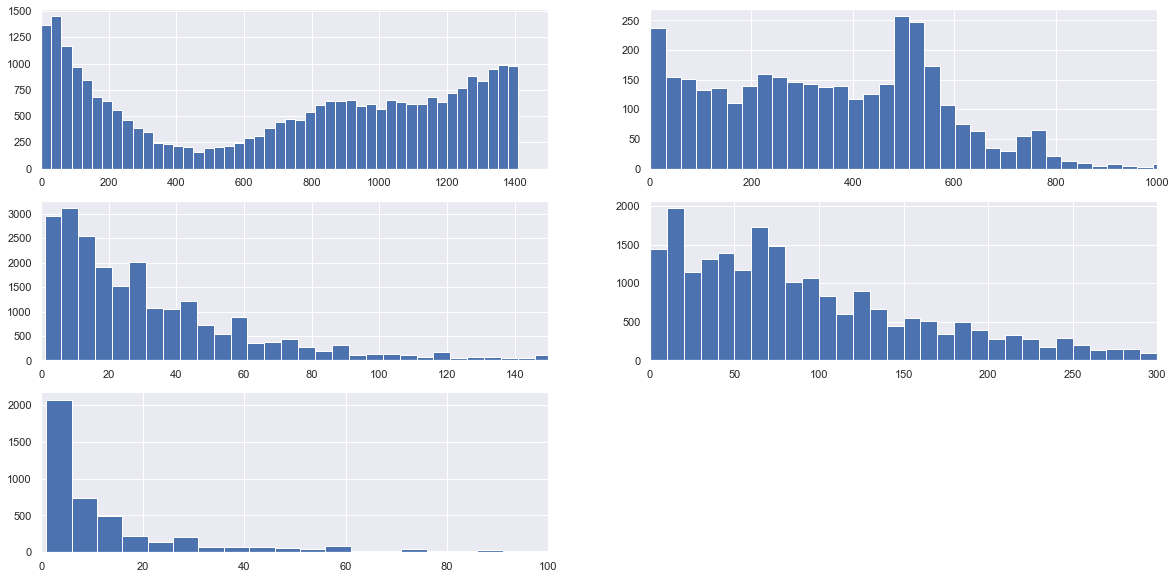

In [18]:
sns.set()
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(20,10))
ax1.hist(aufenthalt_zuhause, bins=range(int(min(aufenthalt_zuhause)), int(max(aufenthalt_zuhause)), 30));
ax1.set_xlim([0, 1500])
ax2.hist(aufenthalt_arbeit, bins=range(int(min(aufenthalt_arbeit)), int(max(aufenthalt_arbeit)), 30));
ax2.set_xlim([0,1000])
ax3.hist(aufenthalt_einkaufen, bins=range(int(min(aufenthalt_einkaufen)), int(max(aufenthalt_einkaufen)), 5));
ax3.set_xlim([0,150])
ax4.hist(aufenthalt_freizeit, bins=range(int(min(aufenthalt_freizeit)), int(max(aufenthalt_freizeit)), 10));
ax4.set_xlim([0,300])
ax5.hist(aufenthalt_sonstiges, bins=range(int(min(aufenthalt_sonstiges)), int(max(aufenthalt_sonstiges)), 5));
ax5.set_xlim([0,100])
fig.delaxes(ax6)

## Ermitteln Verteilungsfunktion über Density Estimation Modell

In [19]:
from sklearn.neighbors import KernelDensity

In [45]:
# Erstellen Kernel Density Estimation Modell Zuhause 
kde_model_zuhause = KernelDensity(bandwidth=50)
kde_model_zuhause.fit(aufenthalt_zuhause[:, np.newaxis])
# übertragen in visaulisierbare Wahrscheinlichkeitsdichtefunktion
x = np.linspace(-50, max(aufenthalt_zuhause), 1000)
log_pdf = kde_model_zuhause.score_samples(x[:, np.newaxis])
kde_zuhause_pdf = np.exp(log_pdf)

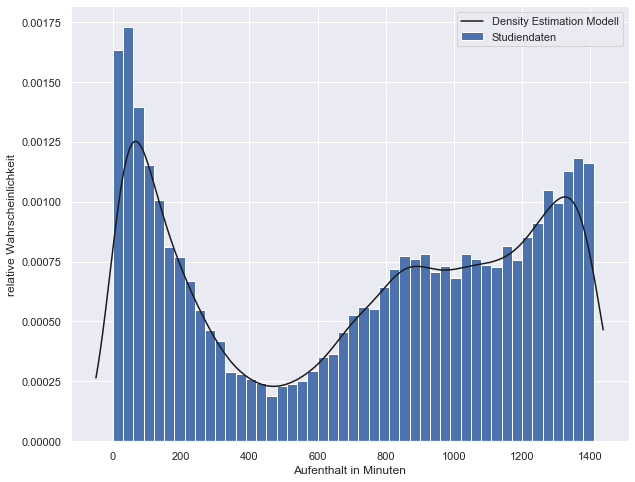

In [46]:
plt.figure(figsize=(10,8))
plt.hist(aufenthalt_zuhause, bins=range(int(min(aufenthalt_zuhause)), int(max(aufenthalt_zuhause)), 30), density=True);
plt.plot(x, kde_zuhause_pdf, '-k');
labels = ["Density Estimation Modell", "Studiendaten"]
plt.legend(labels);
plt.xlabel("Aufenthalt in Minuten");
plt.ylabel("relative Wahrscheinlichkeit");

In [47]:
# Erstellen Kernel Density Estimation Modell Arbeit 
kde_model_arbeit = KernelDensity(bandwidth=40)
kde_model_arbeit.fit(aufenthalt_arbeit[:, np.newaxis])
# übertragen in visaulisierbare Wahrscheinlichkeitsdichtefunktion
x = np.linspace(-50, max(aufenthalt_arbeit), 1000)
log_pdf = kde_model_arbeit.score_samples(x[:, np.newaxis])
kde_arbeit_pdf = np.exp(log_pdf)

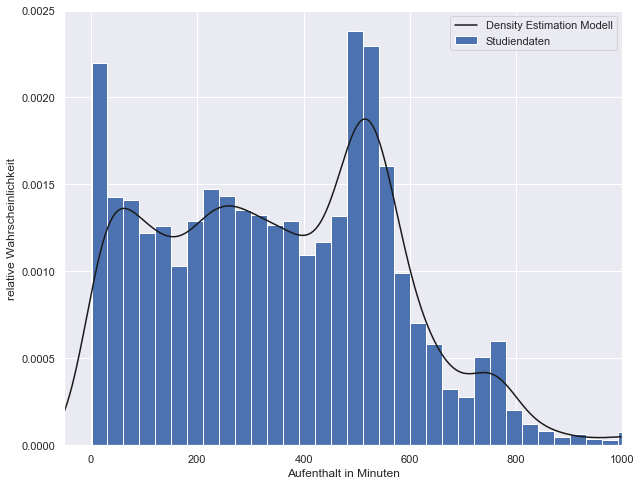

In [48]:
plt.figure(figsize=(10,8))
plt.hist(aufenthalt_arbeit, bins=range(int(min(aufenthalt_arbeit)), int(max(aufenthalt_arbeit)), 30), density=True);
plt.plot(x, kde_arbeit_pdf, '-k');
labels = ["Density Estimation Modell", "Studiendaten"]
plt.legend(labels);
plt.gca().set_xlim(-50, 1000)
plt.xlabel("Aufenthalt in Minuten");
plt.ylabel("relative Wahrscheinlichkeit");

In [24]:
# Erstellen Kernel Density Estimation Modell Einkaufen 
kde_model_einkaufen = KernelDensity(bandwidth=8)
kde_model_einkaufen.fit(aufenthalt_einkaufen[:, np.newaxis])
# übertragen in visaulisierbare Wahrscheinlichkeitsdichtefunktion
x = np.linspace(-50, max(aufenthalt_einkaufen), 1000)
log_pdf = kde_model_einkaufen.score_samples(x[:, np.newaxis])
kde_einkaufen_pdf = np.exp(log_pdf)

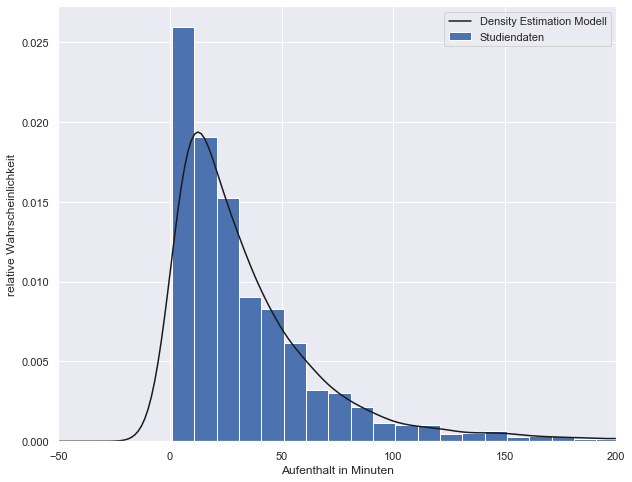

In [25]:
plt.figure(figsize=(10,8))
plt.hist(aufenthalt_einkaufen, bins=range(int(min(aufenthalt_einkaufen)), int(max(aufenthalt_einkaufen)), 10), density=True);
plt.plot(x, kde_einkaufen_pdf, '-k');
labels = ["Density Estimation Modell", "Studiendaten"]
plt.legend(labels);
plt.gca().set_xlim(-50, 200)
plt.xlabel("Aufenthalt in Minuten");
plt.ylabel("relative Wahrscheinlichkeit");

In [38]:
# Erstellen Kernel Density Estimation Modell Freizeit
kde_model_freizeit = KernelDensity(bandwidth=10)
kde_model_freizeit.fit(aufenthalt_freizeit[:, np.newaxis])
# übertragen in visaulisierbare Wahrscheinlichkeitsdichtefunktion
x = np.linspace(-50, max(aufenthalt_freizeit), 1000)
log_pdf = kde_model_freizeit.score_samples(x[:, np.newaxis])
kde_freizeit_pdf = np.exp(log_pdf)

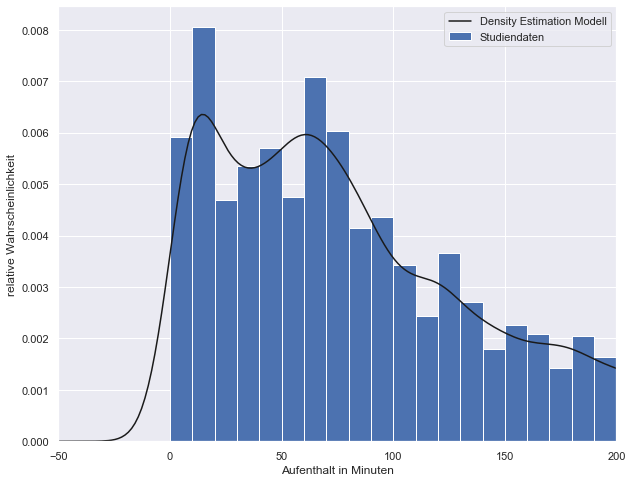

In [39]:
plt.figure(figsize=(10,8))
plt.hist(aufenthalt_freizeit, bins=range(int(min(aufenthalt_freizeit)), int(max(aufenthalt_freizeit)), 10), density=True);
plt.plot(x, kde_freizeit_pdf, '-k');
labels = ["Density Estimation Modell", "Studiendaten"]
plt.legend(labels);
plt.gca().set_xlim(-50, 200)
plt.xlabel("Aufenthalt in Minuten");
plt.ylabel("relative Wahrscheinlichkeit");

In [49]:
# Erstellen Kernel Density Estimation Modell Sonstiges
kde_model_sonstiges = KernelDensity(bandwidth=3)
kde_model_sonstiges.fit(aufenthalt_sonstiges[:, np.newaxis])
# übertragen in visaulisierbare Wahrscheinlichkeitsdichtefunktion
x = np.linspace(-50, max(aufenthalt_sonstiges), 1000)
log_pdf = kde_model_sonstiges.score_samples(x[:, np.newaxis])
kde_sonstiges_pdf = np.exp(log_pdf)

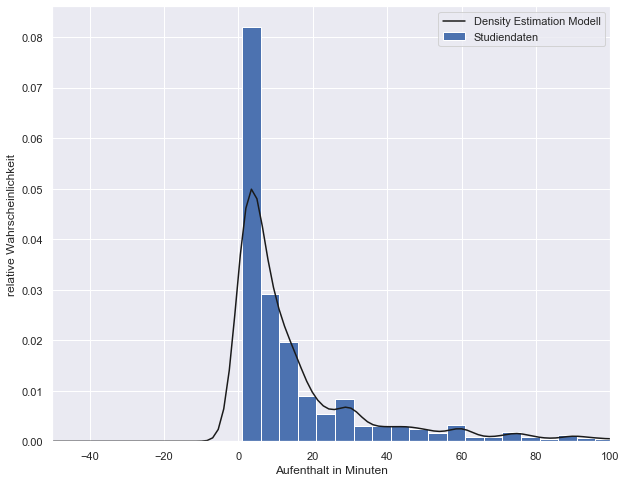

In [50]:
plt.figure(figsize=(10,8))
plt.hist(aufenthalt_sonstiges, bins=range(int(min(aufenthalt_sonstiges)), int(max(aufenthalt_sonstiges)), 5), density=True);
plt.plot(x, kde_sonstiges_pdf, '-k');
labels = ["Density Estimation Modell", "Studiendaten"]
plt.legend(labels);
plt.gca().set_xlim(-50, 100)
plt.xlabel("Aufenthalt in Minuten");
plt.ylabel("relative Wahrscheinlichkeit");

### Lognormal Verteilung für Sonstiges besser -> Anpassen

## Modelle speichern

In [51]:
from pathlib import Path
import pickle
import os

root = os.getcwd()
if not os.path.exists(os.getcwd()+ "\\Simulationsdaten"):
    os.makedirs(root+"\\Simulationsdaten")

# Modelle in Liste zusammenfassen
models = [kde_model_zuhause, kde_model_arbeit, kde_model_einkaufen, kde_model_freizeit, kde_model_sonstiges]
    
path = root+"\\Simulationsdaten\\Modelle_Aufenthaltsdauer_Samstag.pickle"
pickle.dump(models, open(path, "wb"))


In [25]:
print(root)

C:\Users\thoma\Desktop\ev-modelling-repo\Datenauswertung
